Overview:

- Calculate benchmarking scores using CO original implementation implementation
- Visualize the scores of CO vs other GRN methods
- Visualize the stats of class misbalance in the case of the original imeplentation
- Calculate benchmarking scores using the alternative implementation
- Visualize the scores of CO vs other GRN methods
- Visualize the stats of class misbalance in the case of the alternative imeplentation

To reproduce the results, pls follow these steps:
- Download "https://drive.google.com/file/d/17C9-PNcroDtFycnMBxoNNjbEk1Fcwo_X/view?usp=drive_link"
- Unzip and place the folder under 'external' folder

After, you should have a directory in the main directory as 'external/data', which contains the essential data.

Then, install the package from the main directory `pip install .`

Different samples: 100%|██████████| 13/13 [34:06<00:00, 157.39s/it]


output -> C:/Users/nourisa/Documents/testProjs/ongoing/CellOracle_evaluation/results/CO/benchmark/scores_CO/grn_score_summary_22.parquet


Run for metrics: 100%|██████████| 2/2 [00:00<00:00, 399.51it/s]


output -> C:/Users/nourisa/Documents/testProjs/ongoing/CellOracle_evaluation/results/CO/benchmark/scores_CO/scores_all_auc.csv
output -> C:/Users/nourisa/Documents/testProjs/ongoing/CellOracle_evaluation/results/CO/benchmark/scores_CO/scores_all_epr.csv
output -> C:/Users/nourisa/Documents/testProjs/ongoing/CellOracle_evaluation/results/CO/benchmark/scores_CO/figures/auc.png
output -> C:/Users/nourisa/Documents/testProjs/ongoing/CellOracle_evaluation/results/CO/benchmark/scores_CO/figures/epr.png


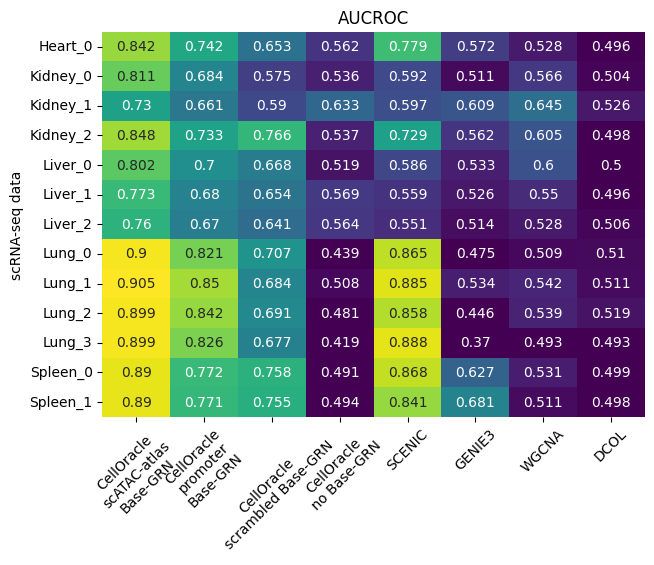

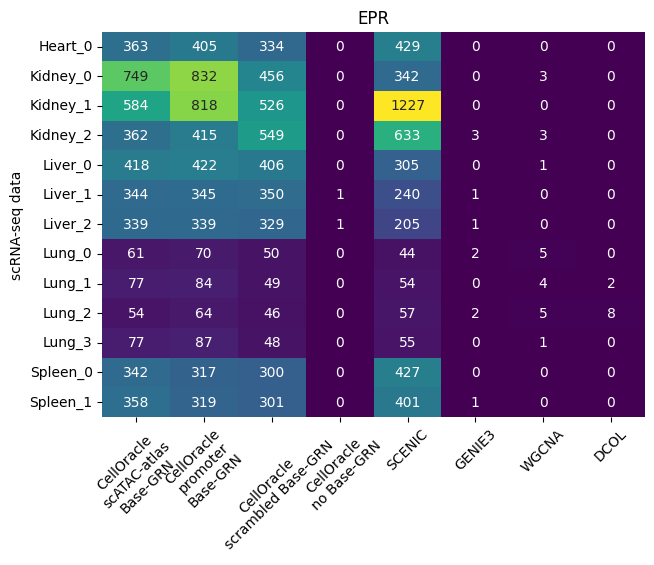

In [2]:
# calculate benchmarking scores using original imeplementation
%run ../CO_evaluation/post_GRN/calculate_scores_CO.py --benchmark-method CO --verbose 
# plot the scores as a heatmap 
%run ../CO_evaluation/post_GRN/plot_scores.py --verbose --benchmark-method CO

output -> C:/Users/nourisa/Documents/testProjs/ongoing/CellOracle_evaluation/results/CO/benchmark/stats/plot_CO.png


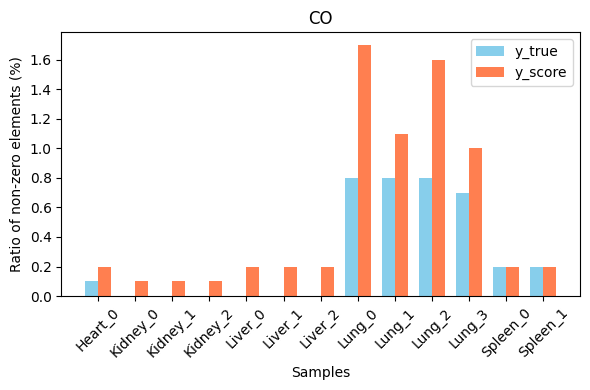

In [5]:
# calculate  and show the significane of class misbalance in the original implementation of CO 
%run ../CO_evaluation/post_GRN/benchmarking_stats.py --benchmark-method CO --verbose --force
%run ../CO_evaluation/post_GRN/plot_benchmarking_stats.py --benchmark-method CO --verbose

In [6]:
# calculate benchmarking scores using the alternative formulation
%run ../CO_evaluation/post_GRN/calculate_scores_CO.py --benchmark-method M1 --verbose 
# plot the scores 
%run ../CO_evaluation/post_GRN/plot_scores.py --verbose --benchmark-method M1

Different samples:  46%|████▌     | 6/13 [05:24<07:52, 67.55s/it]

output -> C:/Users/nourisa/Documents/testProjs/ongoing/CellOracle_evaluation/results/CO/benchmark/stats/plot_M1.png


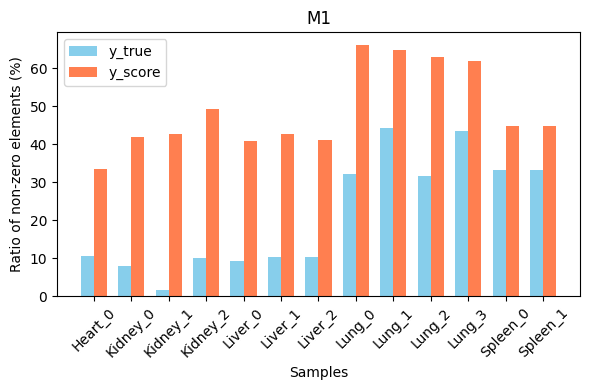

In [9]:
# Show the class misbalance stats for the alternative implementation
# %run ../CO_evaluation/post_GRN/benchmarking_stats.py --benchmark-method M1 --verbose --force
%run ../CO_evaluation/post_GRN/plot_benchmarking_stats.py --benchmark-method M1 --verbose